# Converting Spreads to MoneyLines (MLs)

### Expand [this reddit dataset](https://www.reddit.com/r/sportsbook/comments/3ep6q4/equation_to_convert_point_spread_to_oddsmoneyline/cthzcxd?utm_source=share&utm_medium=web2x) to have all the historical spreads. 

### Method:
- Fit a polynomial of best fit through the points in the reddit dataset.
- For the historical spreads that don't appear on the reddit sheet, map them to the polynomial.
- Fix the MoneyLines that appear to be way off - i.e. -14.5 is less than -14
- Save as 'spreads-to-ml-final.csv'

### Output
'spreads-to-ml-final.csv', a DataFrame of two columns - all historical spreads and their corresponding ML


Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Open and explore the reddit dataset. It has the average moneylines for each spread over the last 5 years.

In [2]:
df = pd.read_csv("extra-nfl/spread_to_ml.csv")

In [3]:
print(df.shape)
df.head()

(61, 6)


,game_count,spread,avg_moneyline,avg_moneyline.1,MAX(moneyline),MIN(moneyline)
0,1,-27.0,-6434,6434,-6434,-6434
1,1,-19.5,-4060,4060,-4060,-4060
2,4,-16.0,-1432,1432,-1334,-1522
3,1,-14.5,-813,813,-813,-813
4,4,-14.0,-1044,1044,-912,-1138


In [4]:
df.tail()

,game_count,spread,avg_moneyline,avg_moneyline.1,MAX(moneyline),MIN(moneyline)
56,4,14.0,727,727,771,649
57,1,14.5,605,605,605,605
58,4,16.0,929,929,948,894
59,1,19.5,1500,1500,1500,1500
60,1,27.0,1500,1500,1500,1500


Filter to the columns we're interested in

In [5]:
df = df[['spread', 'avg_moneyline']]

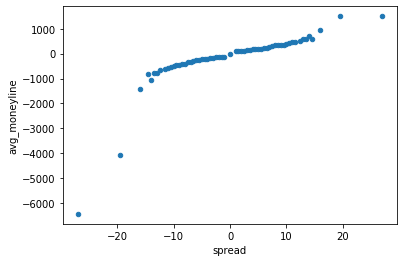

In [6]:
df.plot(kind='scatter', x='spread', y='avg_moneyline')

Fit a polynomial of size 3 through the data, then visualize it

In [7]:
z = np.polyfit(df['spread'], df['avg_moneyline'], 3)
print(z)

[  0.16931585  -3.06287724  31.87552001 167.83612448]


In [8]:
p = np.poly1d(z)
print(p)

        3         2
0.1693 x - 3.063 x + 31.88 x + 167.8


In [9]:
print("A spread of -6 has an ML of {}, while a spread of +6 has an ML of {}".format(p(-6), p(6)))

A spread of -6 has an ML of -170.25279897953888, while a spread of +6 has an ML of 285.3978868869914


It doesn't look to be too good for the low numbers, but that's fine - we mainly need it for the larger ones that aren't in the dataset.

In [10]:
print("A spread of -15 has an ML of {}, while a spread of +15 has an ML of {}".format(p(-15), p(15)))

A spread of -15 has an ML of -1570.8850362748765, while a spread of +15 has an ML of 528.2625286291019


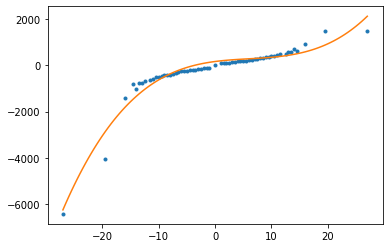

In [11]:
x = df['spread']
y = df['avg_moneyline']
xp = np.linspace(-27, 27, 109)
_ = plt.plot(x, y, '.', xp, p(xp), '-')

### Fill in missing spreads

In [12]:
dir_nfl = './nfl-scores-and-betting-data/'

In [13]:
scores = pd.read_csv(os.path.join(dir_nfl, 'spreadspoke_scores.csv'))

In [14]:
scores.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail'],
      dtype='object')

In [15]:
scores_spreads = scores.spread_favorite.dropna().unique()
print(scores_spreads)

[-14.  -13.5 -18.  -12.   -2.5  -6.   -1.   -6.5  -3.   -7.   -4.   -2.
 -15.   -7.5  -3.5  -5.    0.   -8.  -13.   -9.  -10.  -11.   -4.5  -8.5
  -9.5 -10.5  -5.5  -1.5 -12.5 -14.5 -15.5 -17.  -11.5 -16.  -19.5 -17.5
 -20.  -19.  -16.5 -24.  -18.5 -24.5 -20.5 -22.5 -26.5 -21.5 -21. ]


Find the spreads from scores df missing from the reddit dataset

In [20]:
missing = [spread for spread in scores_spreads if spread not in df.spread.unique()]

Since the scores data only has the favorite spread (i.e. the (-) values), we also want those same values for the underdogs - we want to determine if it's worth betting on them too.

In [21]:
pos_missing = [spread*-1 for spread in missing]
missing.extend(pos_missing)
missing = [spread for spread in missing if spread not in df.spread.unique()]

In [26]:
missing_dict = {spread: p(spread) for spread in missing}
missing_df = pd.DataFrame.from_dict(missing_dict, orient='index', columns=['avg_moneyline']).reset_index().rename(columns={'index':'spread'})

In [27]:
print(missing_df.shape)
missing_df.head()

(34, 2)


,spread,avg_moneyline
0,-18.0,-2385.745478
1,-12.0,-948.302221
2,-15.0,-1570.885036
3,-15.5,-1692.601740
4,-17.0,-2091.067992


In [28]:
df = df.append(missing_df, ignore_index=True).sort_values(by='spread').reset_index().drop(columns=['index'])

In [29]:
df.head()

,spread,avg_moneyline
0,-27.0,-6434.000000
1,-26.5,-5978.675107
2,-24.5,-4941.586182
3,-24.0,-4702.015908
4,-22.5,-4028.557992


Plot the data

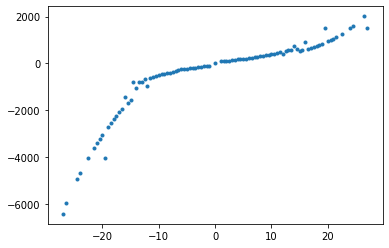

In [30]:
x = df['spread']
y = df['avg_moneyline']
_ = plt.plot(x, y, '.')

Let's adjust those that are probably slightly off - make them = to the polynomial, or average the previous and the next one.

In [31]:
for i in range(df.shape[0]):
    if i == df.shape[0] - 1:
        break
    if i == 0:
        continue
    ml = df['avg_moneyline'].iloc[i]
    prev_ml = df['avg_moneyline'].iloc[i-1]
    next_ml = df['avg_moneyline'].iloc[i+1]
    if ml < prev_ml:
        df.avg_moneyline.iloc[i] = max(ml, p(df.spread.iloc[i]), (prev_ml+next_ml)/2)
        print("Spread {}: {} -> {}".format(df.spread.iloc[i], ml, df.avg_moneyline.iloc[i]))

Spread -19.5: -4060.0 -> -2873.8514231502945
Spread -15.5: -1692.6017401269312 -> -1501.4425181374381
Spread -15.0: -1570.8850362748765 -> -1157.221259068719
Spread -14.0: -1044.0 -> -794.5
Spread -13.0: -780.0 -> -723.0
Spread -12.0: -948.3022206966181 -> -643.5
Spread -8.0: -408.0 -> -369.88189222988467
Spread 12.0: 401.865825430798 -> 493.0
Spread 13.5: 571.0 -> 651.0
Spread 14.5: 605.0 -> 627.6312643145509
Spread 15.0: 528.2625286291019 -> 592.0963705349261
Spread 15.5: 556.5614767553013 -> 760.548185267463
Spread 16.5: 620.5018243378246 -> 792.6985987820265
Spread 17.0: 656.3971975640528 -> 743.8886425211106
Spread 17.5: 695.0786862601947 -> 740.2809599161565
Spread 18.0: 736.6732773112025 -> 760.7944587590923
Spread 20.0: 934.7224027629329 -> 1246.3936544312755
Spread 20.5: 992.787308862551 -> 1150.4604465290113
Spread 21.0: 1054.5272386267468 -> 1135.2648127347422
Spread 21.5: 1120.0691789404732 -> 1199.1659257455337


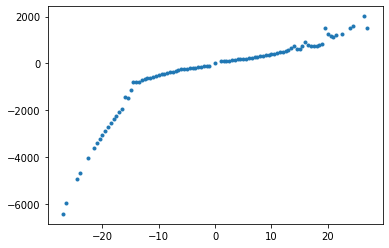

In [33]:
x = df['spread']
y = df['avg_moneyline']
plt.plot(x, y, '.')

In [34]:
df.iloc[47].avg_moneyline = -110.

In [35]:
df.iloc[47]

spread             0.0
avg_moneyline   -110.0
Name: 47, dtype: float64

In [36]:
df.to_csv('extra-nfl/spread_to_ml_final.csv')